In [2]:
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import notebook_libs.utilities as util
import notebook_libs.prometheus as prom

# Experiment in Progress - Client Data

In [ ]:
print(f"Updated {datetime.datetime.now()}")
df = util.read_client_requests_in_progress()
f, ax = plt.subplots(figsize=[8,4])
util.plot_client_latency_distribution(df, "in-progress", ax)
plt.show()
result = prom.fetch_experiment_pod_data(int(14000/60.))
util.plot_pod_metrics(result)
plt.show()

# Completed Experiments

In [ ]:
print("\n".join([f"{i}: {x}" for i, x in enumerate(util.all_experiments)]))

In [ ]:
print("\n".join([f"{i}: {x}" for i, x in enumerate(util.experiments_10_1500)]))

In [ ]:
current_experiment = util.all_experiments[29]

## 1-Minute buckets for client request data

In [ ]:
df, first_request_time, final_request_time = util.read_client_requests(current_experiment)
df_bucket = util.create_1_min_bucket_client_metrics(df)
df_bucket.plot(y=[
    "request_rate_per_min", 
    "avg_client_latency_ms",
    "std_client_latency_ms",
    "avg_response_function_latency_ms",
    "std_response_function_latency_ms"
]
,figsize=[8,12]
,title="Client Metrics (1Min Buckets)")

## Compare a Group of Experiments

In [ ]:
util.compare_client_latency_distributions(util.experiments_10_1500)

## Experiment Complete - Compare data window between Client and Prometheus

In [ ]:
df_pod = util.read_pod_df_list(current_experiment, first_request_time, final_request_time)
util.plot_pod_metrics(df_pod)

In [ ]:
df = util.combined_data_set(current_experiment)
df.head(10)

In [ ]:
df.plot.scatter(x="request_rate_per_min",y="cpu")
df.plot.scatter(x="request_rate_per_min",y="memory")

# Workload Response Model

In [3]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

2023-03-01 10:40:59.892072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df = util.combined_data_sets(util.experiments_10_250)
print(df.head(4))

                  memory       cpu  request_rate_per_min  \
timestamp                                                  
1676685600  4.551111e+01  0.007186                  49.0   
1676685660  2.226540e+06  0.068497                  46.0   
1676685720  6.900213e+06  0.079064                  48.0   
1676685780  1.755182e+06  0.098106                  45.0   

            avg_client_latency_ms  std_client_latency_ms  \
timestamp                                                  
1676685600             574.022405              58.230970   
1676685660             609.304216              68.931421   
1676685720             608.947660              74.371525   
1676685780             594.807487              76.878553   

            avg_response_function_latency_ms  \
timestamp                                      
1676685600                        502.168101   
1676685660                        516.961036   
1676685720                        525.960113   
1676685780                        510.

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='replicas'>

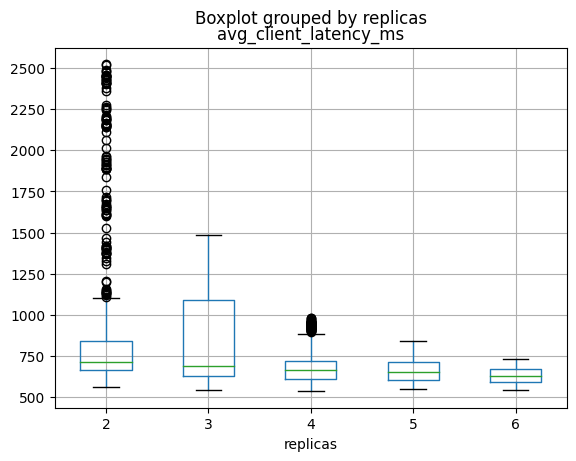

In [5]:
df.boxplot("avg_client_latency_ms", by="replicas")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_req_rate'>

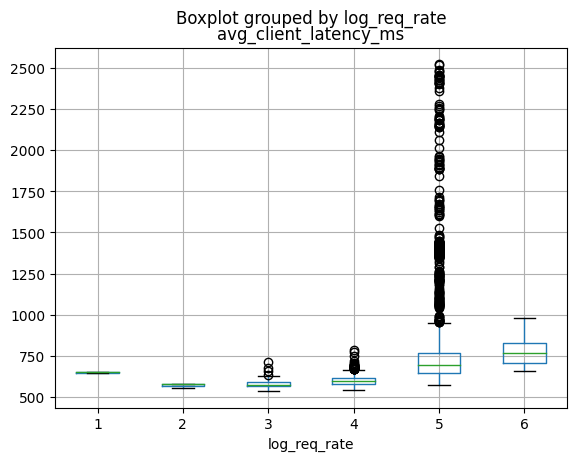

In [6]:
df["log_req_rate"] = df["request_rate_per_min"].apply(lambda x: int(np.log(x)))
df.boxplot("avg_client_latency_ms", by="log_req_rate")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_memory'>

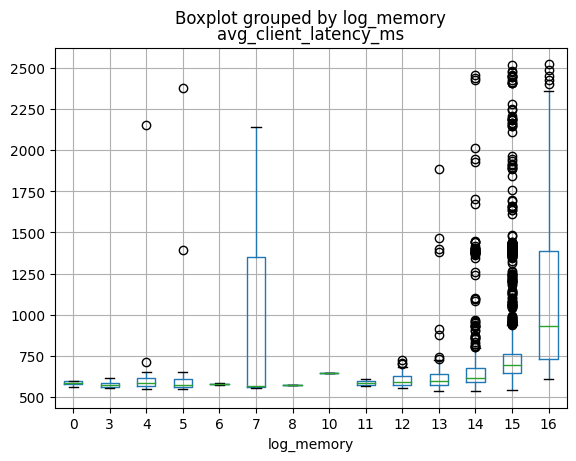

In [7]:
df["log_memory"] = df.memory.apply(lambda x: int(np.log(x+1)))
df.boxplot("avg_client_latency_ms", by="log_memory")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_cpu'>

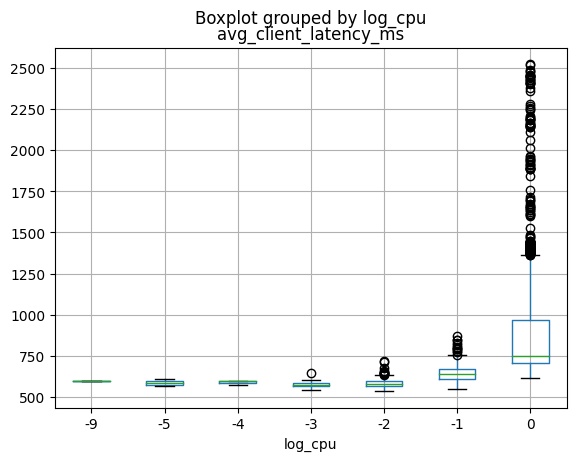

In [8]:
df["log_cpu"] = df.cpu.apply(lambda x: int(np.log(x)))
df.boxplot("avg_client_latency_ms", by="log_cpu")

In [9]:
# REMOVE memory 2023-02-28 
# df_train = df[[ "memory", "cpu", "request_rate_per_min", "avg_client_latency_ms", "replicas"]].copy()
df_train = df[[ "cpu", "request_rate_per_min", "avg_client_latency_ms", "replicas"]].copy()
df_train["avg_client_latency_ms"] = df_train["avg_client_latency_ms"].apply(lambda x: np.log(x))

In [10]:
scaler.fit(df_train)
scaled = scaler.transform(df_train)
# REMOVE memory 2023-02-28 
# X = scaled[:,[2,4]]
X = scaled[:,[1,3]]
# REMOVE memory 2023-02-28 
# y = scaled[:,[0,1,3]]
y = scaled[:,[0,2]]

In [11]:
model = Sequential()
model.add(Dense(10, input_shape=(2,), activation='relu'))
model.add(Dense(12, activation='relu'))
# REMOVE memory 2023-02-28 
# model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=165, batch_size=30)

# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

2023-03-01 10:41:15.312415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/165
104/104 [==============================] - 1s 2ms/step - loss: 0.0535 - accuracy: 0.8871
Epoch 2/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0171 - accuracy: 0.9474
Epoch 3/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.9361
Epoch 4/165
104/104 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.9371
Epoch 5/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9361
Epoch 6/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9309
Epoch 7/165
104/104 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9297
Epoch 8/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.9258
Epoch 9/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.9242
Epoch 10/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0055 - accura

104/104 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 0.9568
Epoch 82/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9597
Epoch 83/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9597
Epoch 84/165
104/104 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9584
Epoch 85/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9571
Epoch 86/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9574
Epoch 87/165
104/104 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9610
Epoch 88/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9600
Epoch 89/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9600
Epoch 90/165
104/104 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 

104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9577
Epoch 161/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9561
Epoch 162/165
104/104 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9597
Epoch 163/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9577
Epoch 164/165
104/104 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9606
Epoch 165/165
97/97 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9590
Accuracy: 95.90


In [12]:
def scan_for_replicas(model, scaler, req_rate, last_n, latency_target = 650, delta_n = 3, n_min = 2, n_max = 6):
    lat_data = []
    ns = np.array(range(max(n_min, last_n-delta_n), min(last_n+delta_n, n_max)))
    for n in ns:
        # REMOVE memory 2023-02-28 
        # X = scaler.transform(np.array([0, 0, req_rate, 0, n]).reshape(1, -1))[:,[2,4]]
        X = scaler.transform(np.array([0, req_rate, 0, n]).reshape(1, -1))[:,[1,3]]
        _y = model.predict(X)[0]
        # REMOVE memory 2023-02-28 
        # pred_lat = scaler.inverse_transform(np.array([_y[0], _y[1], req_rate, _y[2], n]).reshape(1, -1))
        pred_lat = scaler.inverse_transform(np.array([_y[0], req_rate, _y[1], n]).reshape(1, -1))
        # REMOVE memory 2023-02-28 
        # lat_data.append(pred_lat[0][3])
        lat_data.append(pred_lat[0][2])
    i, = np.where(np.array(lat_data) < np.log(latency_target))
    #print("target ", np.log(latency_target))
    #print("latency", lat_data)
    #print("     ns", ns)
    #print(i, ns[i])
    #print(min(ns[i]))
    try:
        res = min(ns[i])
    except (ValueError) as e:
        res = n_max
    return res

In [20]:
req_rate_v_n_data=[]
for rr in range(60, 350, 5):
    req_rate_v_n_data.append((rr, scan_for_replicas(model, scaler, rr, 4)))

1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


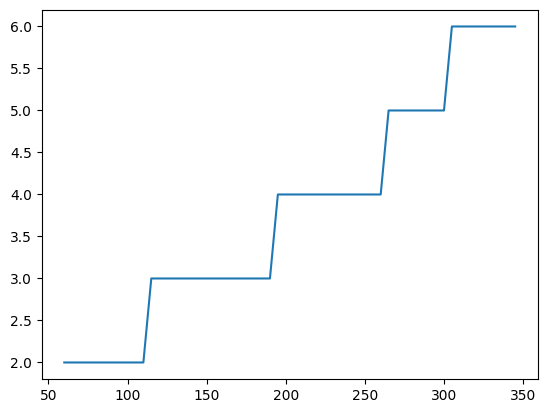

In [21]:
req_rate_v_n_data = np.array(req_rate_v_n_data)
plt.plot(req_rate_v_n_data.T[0], req_rate_v_n_data.T[1])    

### To Do
* correlations between client and server metrics
* what parameters to scan with more tests?
* how long is 10K transactions?

In [ ]:
a={
    "b": [1,2,3,4],
    "c": [6,7,8,8]
}
x = pd.DataFrame(a, columns=["b", "c", "d"])
print(x)